i

In [1]:
from google.colab import drive
import zipfile
import os

# Mount Drive
drive.mount('/content/drive')

# Define paths
zip_path = "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip"
extract_path = "/content/dataset"

# Unzip if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted!")
else:
    print("Dataset already extracted.")


Mounted at /content/drive
Dataset extracted!


In [3]:
# Restart runtime to clear memory (run this cell first, then rerun after restart)
import os
if not os.path.exists('/content/restarted.txt'):
    with open('/content/restarted.txt', 'w') as f:
        f.write('restarted')
    raise SystemExit("Please rerun this cell to continue after runtime restart.")

In [4]:

!pip install torch torchvision pycocotools numpy pillow matplotlib pandas albumentations
!pip install git+https://github.com/facebookresearch/detectron2.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [5]:
import json
from detectron2.data import MetadataCatalog

# Patch MetadataCatalog to bypass assertion check
original_setattr = MetadataCatalog.__setattr__
def patched_setattr(self, key, val):
    if key == 'thing_classes' and key in self.__dict__:
        print(f"Overwriting {key} for {self.name}: {self.__dict__[key]} -> {val}")
        self.__dict__[key] = val
    else:
        original_setattr(self, key, val)
MetadataCatalog.__setattr__ = patched_setattr


In [6]:
import numpy as np
import torch
import cv2
from detectron2.data import DatasetCatalog
import detectron2.data.datasets.builtin  # To override COCO registrations
from detectron2.data.datasets import register_coco_instances
from glob import glob
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from pycocotools.coco import COCO
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [7]:

# Disable built-in COCO dataset registrations
detectron2.data.datasets.builtin._PREDEFINED_SPLITS_COCO = {}


In [ ]:
# Colab display helper
try:
    from google.colab.patches import cv2_imshow
except ImportError:
    def cv2_imshow(img):
        cv2.imshow("Image", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


In [8]:
# Paths
DATASET_ROOT = '/content/_dataset'
TRAIN_DIR = '/content/dataset/train-300/data'
TRAIN_ANN_FILE = '/content/dataset/train-300/labels.json'
VAL_DIR = '/content/dataset/validation-300/data'
VAL_ANN_FILE = '/content/dataset/validation-300/labels.json'
TEST_IMAGES_DIR = '/content/dataset/test-30'
MODEL_PATH = '/content/drive/MyDrive/panoptic_4classes.pth'
OUTPUT_DIR = '/content/drive/MyDrive/test_predictions'
TRAIN_OUTPUT_DIR = '/content/drive/MyDrive/panoptic_output'


In [9]:
# Debug: Check directories
for path in [TRAIN_DIR, VAL_DIR, TEST_IMAGES_DIR, TRAIN_ANN_FILE, VAL_ANN_FILE]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path not found: {path}")
train_files = glob(os.path.join(TRAIN_DIR, '*.*'))
val_files = glob(os.path.join(VAL_DIR, '*.*'))
test_files = glob(os.path.join(TEST_IMAGES_DIR, '*.*'))
print(f"Files in train directory ({len(train_files)}):", [os.path.basename(f) for f in train_files[:5]])
print(f"Files in val directory ({len(val_files)}):", [os.path.basename(f) for f in val_files[:5]])
print(f"Files in test directory ({len(test_files)}):", [os.path.basename(f) for f in test_files[:5]])

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TRAIN_OUTPUT_DIR, exist_ok=True)


Files in train directory (300): ['000000005325.jpg', '000000000071.jpg', '000000016356.jpg', '000000006811.jpg', '000000012993.jpg']
Files in val directory (300): ['000000135410.jpg', '000000127092.jpg', '000000198928.jpg', '000000100283.jpg', '000000067616.jpg']
Files in test directory (30): ['000000001702.jpg', '000000001439.jpg', '000000001380.jpg', '000000001600.jpg', '000000001583.jpg']


In [10]:

# Debug: Check categories in original labels.json
def check_labels_json(path):
    with open(path) as f:
        data = json.load(f)
    categories = [(cat['id'], cat['name']) for cat in data['categories']]
    print(f"Categories in {path}:", sorted(categories, key=lambda x: x[0]))
    target_ids = [15, 16, 25, 41]
    target_categories = [(cat['id'], cat['name']) for cat in data['categories'] if cat['id'] in target_ids]
    print(f"Target categories in {path} (IDs {target_ids}):", target_categories)
    return data

train_labels = check_labels_json(TRAIN_ANN_FILE)
val_labels = check_labels_json(VAL_ANN_FILE)

Categories in /content/dataset/train-300/labels.json: [(0, 'airplane'), (1, 'backpack'), (2, 'banana'), (3, 'baseball bat'), (4, 'baseball glove'), (5, 'bear'), (6, 'bench'), (7, 'bicycle'), (8, 'bird'), (9, 'boat'), (10, 'book'), (11, 'bottle'), (12, 'bowl'), (13, 'broccoli'), (14, 'bus'), (15, 'cake'), (16, 'car'), (17, 'carrot'), (18, 'cat'), (19, 'cell phone'), (20, 'chair'), (21, 'clock'), (22, 'cow'), (23, 'cup'), (24, 'dining table'), (25, 'dog'), (26, 'donut'), (27, 'elephant'), (28, 'fire hydrant'), (29, 'fork'), (30, 'frisbee'), (31, 'giraffe'), (32, 'handbag'), (33, 'horse'), (34, 'hot dog'), (35, 'kite'), (36, 'knife'), (37, 'laptop'), (38, 'motorcycle'), (39, 'oven'), (40, 'parking meter'), (41, 'person'), (42, 'pizza'), (43, 'potted plant'), (44, 'refrigerator'), (45, 'remote'), (46, 'sandwich'), (47, 'scissors'), (48, 'skateboard'), (49, 'skis'), (50, 'spoon'), (51, 'sports ball'), (52, 'stop sign'), (53, 'suitcase'), (54, 'surfboard'), (55, 'tennis racket'), (56, 'tie')

In [11]:
# --- Step 1: Filter labels.json ---
def filter_labels_json(input_path, output_path, target_cat_ids, image_dir):
    with open(input_path) as f:
        data = json.load(f)

    # Enforce category mapping
    cat_id_to_name = {15: 'cake', 16: 'car', 25: 'dog', 41: 'person'}
    filtered_categories = [
        {'id': cat_id, 'name': cat_id_to_name[cat_id], 'supercategory': 'object'}
        for cat_id in target_cat_ids
    ]

    # Get list of available image files
    available_images = set(os.path.basename(f) for f in glob(os.path.join(image_dir, '*.*')))
    print(f"Available images in {image_dir}: {len(available_images)}")

    # Filter images and annotations
    filtered_images = []
    filtered_annotations = []
    image_id_map = {}  # Map old image IDs to new ones
    new_image_id = 0

    for img in data['images']:
        file_name = os.path.basename(img['file_name'])
        if file_name in available_images:
            img['file_name'] = file_name  # Use relative path
            image_id_map[img['id']] = new_image_id
            img['id'] = new_image_id
            filtered_images.append(img)
            new_image_id += 1

    for ann in data['annotations']:
        if ann['category_id'] in target_cat_ids and ann['image_id'] in image_id_map:
            ann['image_id'] = image_id_map[ann['image_id']]
            filtered_annotations.append(ann)

    if not filtered_annotations:
        print(f"Warning: No annotations found for target categories {target_cat_ids} in {input_path}")

    filtered_data = {
        "info": {
        "description": "Filtered COCO-style dataset",
        "version": "1.0",
        "year": 2025,
        "contributor": "_",
        "date_created": "2025-06-16"
           },
        "licenses": [
        {
            "id": 1,
            "name": "Unknown",
            "url": "http://example.com"
        }
                ],
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': filtered_categories
         }

    with open(output_path, 'w') as f:
        json.dump(filtered_data, f)
    print(f"Filtered annotations saved to {output_path}")
    print(f"Filtered images: {len(filtered_images)}, annotations: {len(filtered_annotations)}")
    print(f"Filtered categories: {[(cat['id'], cat['name']) for cat in filtered_data['categories']]}")
    print(f"Annotation category IDs: {set(ann['category_id'] for ann in filtered_annotations)}")
    return filtered_data

In [12]:
target_cat_ids = [15, 16, 25, 41]
TRAIN_ANN_FILE_FILTERED = '/content/dataset/train-300/labels_filtered.json'
VAL_ANN_FILE_FILTERED = '/content/dataset/validation-300/labels_filtered.json'
filter_labels_json(TRAIN_ANN_FILE, TRAIN_ANN_FILE_FILTERED, target_cat_ids, TRAIN_DIR)
filter_labels_json(VAL_ANN_FILE, VAL_ANN_FILE_FILTERED, target_cat_ids, VAL_DIR)


Available images in /content/dataset/train-300/data: 300
Filtered annotations saved to /content/dataset/train-300/labels_filtered.json
Filtered images: 300, annotations: 2438
Filtered categories: [(15, 'cake'), (16, 'car'), (25, 'dog'), (41, 'person')]
Annotation category IDs: {16, 41, 25, 15}
Available images in /content/dataset/validation-300/data: 300
Filtered annotations saved to /content/dataset/validation-300/labels_filtered.json
Filtered images: 300, annotations: 2055
Filtered categories: [(15, 'cake'), (16, 'car'), (25, 'dog'), (41, 'person')]
Annotation category IDs: {16, 41, 25, 15}


{'info': {'description': 'Filtered COCO-style dataset',
  'version': '1.0',
  'year': 2025,
  'contributor': '_',
  'date_created': '2025-06-16'},
 'licenses': [{'id': 1, 'name': 'Unknown', 'url': 'http://example.com'}],
 'images': [{'id': 0,
   'file_name': '000000000724.jpg',
   'height': 500,
   'width': 375,
   'license': None,
   'coco_url': None},
  {'id': 1,
   'file_name': '000000001532.jpg',
   'height': 480,
   'width': 640,
   'license': None,
   'coco_url': None},
  {'id': 2,
   'file_name': '000000001584.jpg',
   'height': 612,
   'width': 612,
   'license': None,
   'coco_url': None},
  {'id': 3,
   'file_name': '000000002006.jpg',
   'height': 480,
   'width': 640,
   'license': None,
   'coco_url': None},
  {'id': 4,
   'file_name': '000000005037.jpg',
   'height': 425,
   'width': 640,
   'license': None,
   'coco_url': None},
  {'id': 5,
   'file_name': '000000006040.jpg',
   'height': 351,
   'width': 640,
   'license': None,
   'coco_url': None},
  {'id': 6,
   'fil

In [13]:
# Debug: Check filtered labels.json
with open(TRAIN_ANN_FILE_FILTERED) as f:
    train_data = json.load(f)
print("Filtered train labels.json categories:", [(cat['id'], cat['name']) for cat in train_data.get('categories', [])])
print("Filtered train labels.json keys:", train_data.keys())
print("Sample image entries:", [img['file_name'] for img in train_data['images'][:5]])


Filtered train labels.json categories: [(15, 'cake'), (16, 'car'), (25, 'dog'), (41, 'person')]
Filtered train labels.json keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
Sample image entries: ['000000000149.jpg', '000000000260.jpg', '000000000328.jpg', '000000000419.jpg', '000000000722.jpg']


In [14]:
with open(VAL_ANN_FILE_FILTERED) as f:
    val_data = json.load(f)
print("Filtered val labels.json categories:", [(cat['id'], cat['name']) for cat in val_data.get('categories', [])])
print("Filtered val labels.json keys:", val_data.keys())
print("Sample image entries:", [img['file_name'] for img in val_data['images'][:5]])


Filtered val labels.json categories: [(15, 'cake'), (16, 'car'), (25, 'dog'), (41, 'person')]
Filtered val labels.json keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
Sample image entries: ['000000000724.jpg', '000000001532.jpg', '000000001584.jpg', '000000002006.jpg', '000000005037.jpg']


In [15]:
def register_datasets():
    # Clear ALL dataset registrations
    print("Existing datasets before cleanup:", list(DatasetCatalog))
    for dataset_name in list(DatasetCatalog):
        DatasetCatalog.remove(dataset_name)
        if dataset_name in MetadataCatalog:
            MetadataCatalog.remove(dataset_name)
    print("Datasets after cleanup:", list(DatasetCatalog))

    thing_classes = ['cake', 'car', 'dog', 'person']
    try:
        register_coco_instances(
            name="my_coco_train_custom",
            metadata={"thing_classes": thing_classes},
            json_file=TRAIN_ANN_FILE_FILTERED,
            image_root=TRAIN_DIR
        )
        register_coco_instances(
            name="my_coco_val_custom",
            metadata={"thing_classes": thing_classes},
            json_file=VAL_ANN_FILE_FILTERED,
            image_root=VAL_DIR
        )
        print("Datasets registered successfully.")
        print("Registered datasets:", list(DatasetCatalog))
        print("Metadata for my_coco_train_custom:", MetadataCatalog.get("my_coco_train_custom").thing_classes)
        print("Metadata for my_coco_val_custom:", MetadataCatalog.get("my_coco_val_custom").thing_classes)
    except Exception as e:
        print(f"Error registering datasets: {e}")
        raise

register_datasets()


Existing datasets before cleanup: ['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5_train_cocofied', 'lvis_v0.5_val_cocofied', 'cityscapes_fine_instance_seg_train', 'citysc

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Categories in filtered train dataset: [(15, 'cake'), (16, 'car'), (25, 'dog'), (41, 'person')]


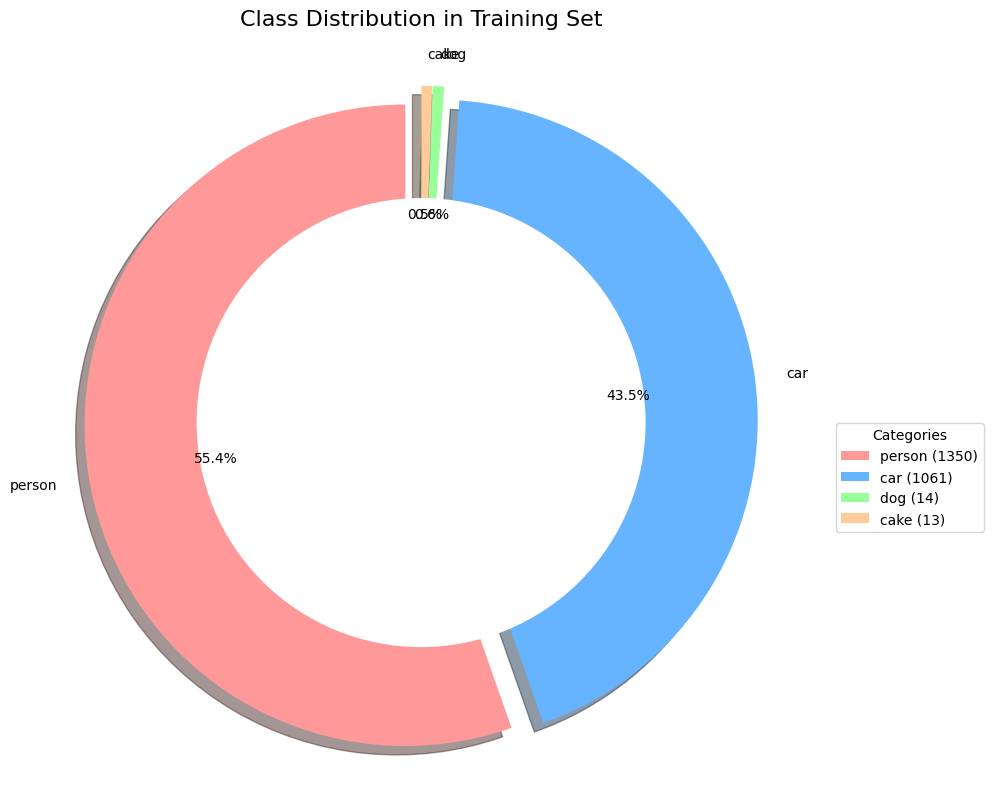

Computed class weights: [np.float64(1.0), np.float64(1.0), np.float64(0.012252591894439209), np.float64(0.9285714285714285), np.float64(0.009629629629629629)]


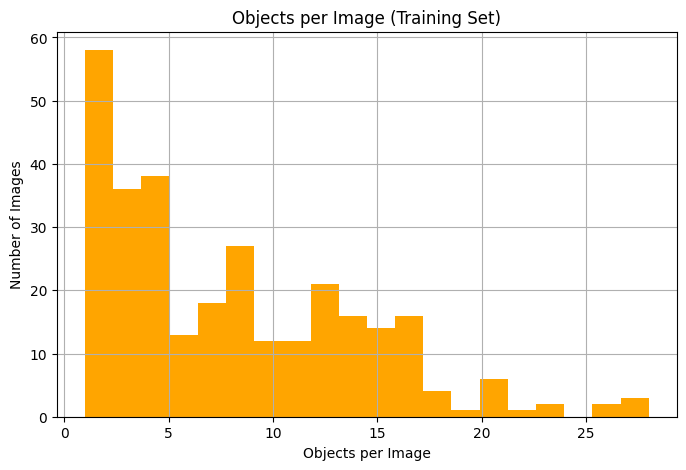

In [25]:

# --- Step 3: Exploratory Data Analysis (EDA) ---
coco_train = COCO(TRAIN_ANN_FILE_FILTERED)
coco_val = COCO(VAL_ANN_FILE_FILTERED)
all_categories = coco_train.loadCats(coco_train.getCatIds())
print("Categories in filtered train dataset:", [(cat['id'], cat['name']) for cat in all_categories])

# Filter annotations
cat_id_to_name = {15: 'cake', 16: 'car', 25: 'dog', 41: 'person'}
filtered_annotations = [ann for ann in coco_train.loadAnns(coco_train.getAnnIds()) if ann['category_id'] in target_cat_ids]
filtered_df = pd.DataFrame(filtered_annotations)
filtered_df['category_name'] = filtered_df['category_id'].map(cat_id_to_name)

# 3.1: Class Distribution
if filtered_df.empty:
    print("Warning: No annotations found for target classes in training set.")
else:
    img_ids = coco_train.getImgIds(catIds=target_cat_ids)
    background_pixels = 0
    total_pixels = 0
    for img_id in img_ids[:10]:
        img_info = coco_train.loadImgs(img_id)[0]
        ann_ids = coco_train.getAnnIds(imgIds=img_id, catIds=target_cat_ids, iscrowd=False)
        anns = coco_train.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            if ann['category_id'] in target_cat_ids:
                mask = np.maximum(mask, coco_train.annToMask(ann))
        background_pixels += (mask == 0).sum()
        total_pixels += mask.size
    background_ratio = background_pixels / total_pixels if total_pixels else 1.0

        # Assuming filtered_df is already created from previous EDA
    class_counts = filtered_df['category_name'].value_counts()

    # Create pie chart with enhanced formatting
    plt.figure(figsize=(10, 8))
    plt.pie(class_counts,
            labels=class_counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'],
            explode=(0.05, 0.05, 0.05, 0.05),  # Explode all slices slightly
            shadow=True)

    # Draw circle to make it a donut chart (optional)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures pie is drawn as circle
    plt.axis('equal')
    plt.title('Class Distribution in Training Set', pad=20, fontsize=16)

    # Add legend with count information
    legend_labels = [f'{label} ({count})' for label, count in zip(class_counts.index, class_counts)]
    plt.legend(legend_labels, title="Categories", loc="best", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig(os.path.join(TRAIN_OUTPUT_DIR, 'class_distribution_pie.png'), dpi=300, bbox_inches='tight')
    plt.show()

    counts = filtered_df['category_name'].value_counts()
    total = counts.sum()
    weights = {cat: total / count for cat, count in counts.items()}
    weights['background'] = total / (background_ratio * total) if background_ratio else 1.0
    normalized_weights = [weights.get('background', 0.1)] + [weights.get(cat, 1.0) / max(weights.values()) for cat in ['cake', 'car', 'dog', 'person']]
    print("Computed class weights:", normalized_weights)

    # 3.2: Objects per Image
    image_obj_count = filtered_df['image_id'].value_counts()
    plt.figure(figsize=(8, 5))
    plt.hist(image_obj_count.values, bins=20, color='orange')
    plt.title('Objects per Image (Training Set)')
    plt.xlabel('Objects per Image')
    plt.ylabel('Number of Images')
    plt.grid(True)
    plt.savefig(os.path.join(TRAIN_OUTPUT_DIR, 'objects_per_image.png'))
    plt.show()




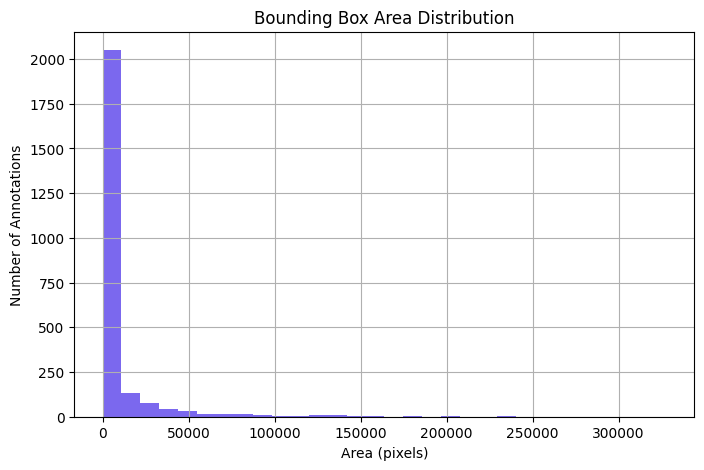

In [19]:
areas = filtered_df['area']
plt.figure(figsize=(8, 5))
plt.hist(areas, bins=30, color='mediumslateblue')
plt.title('Bounding Box Area Distribution')
plt.xlabel('Area (pixels)')
plt.ylabel('Number of Annotations')
plt.grid(True)
plt.savefig(os.path.join(TRAIN_OUTPUT_DIR, 'bbox_area_distribution.png'))
plt.show()


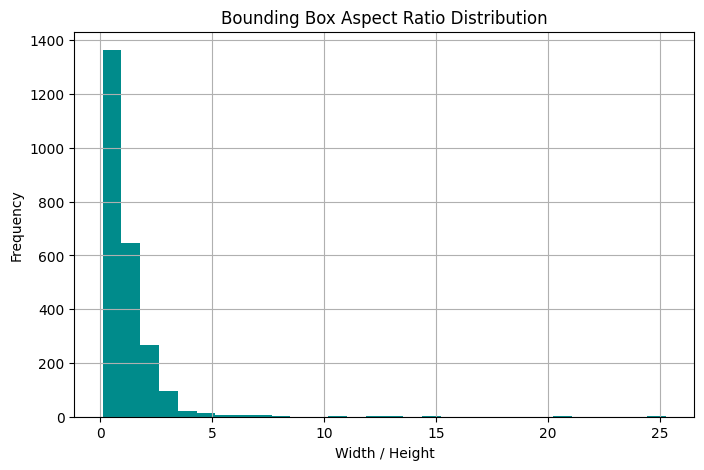

In [20]:
aspect_ratios = []
for ann in filtered_annotations:
    bbox = ann['bbox']  # format: [x, y, width, height]
    if bbox[3] > 0:
        aspect_ratio = bbox[2] / bbox[3]
        aspect_ratios.append(aspect_ratio)

plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=30, color='darkcyan')
plt.title('Bounding Box Aspect Ratio Distribution')
plt.xlabel('Width / Height')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(os.path.join(TRAIN_OUTPUT_DIR, 'bbox_aspect_ratio_distribution.png'))
plt.show()


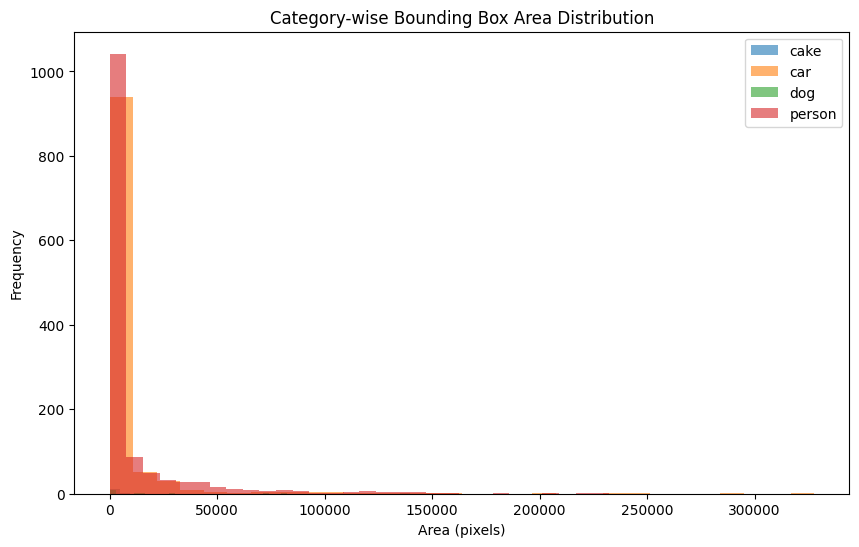

In [21]:
bbox_sizes = {cat: [] for cat in cat_id_to_name.values()}
for ann in filtered_annotations:
    cat = cat_id_to_name[ann['category_id']]
    bbox = ann['bbox']
    bbox_area = bbox[2] * bbox[3]
    bbox_sizes[cat].append(bbox_area)

plt.figure(figsize=(10, 6))
for cat, areas in bbox_sizes.items():
    plt.hist(areas, bins=30, alpha=0.6, label=cat)
plt.title('Category-wise Bounding Box Area Distribution')
plt.xlabel('Area (pixels)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig(os.path.join(TRAIN_OUTPUT_DIR, 'category_bbox_area.png'))
plt.show()


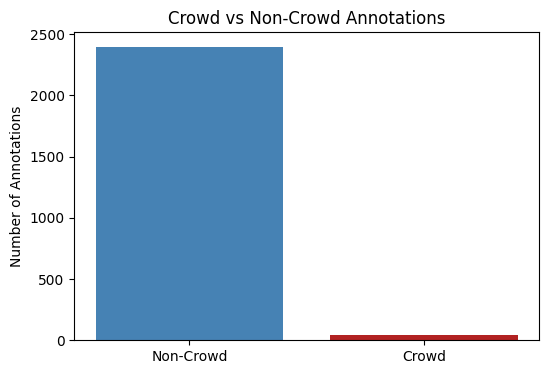

In [22]:
iscrowd_counts = filtered_df['iscrowd'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(['Non-Crowd', 'Crowd'], [iscrowd_counts.get(0, 0), iscrowd_counts.get(1, 0)], color=['steelblue', 'firebrick'])
plt.title('Crowd vs Non-Crowd Annotations')
plt.ylabel('Number of Annotations')
plt.savefig(os.path.join(TRAIN_OUTPUT_DIR, 'crowd_vs_noncrowd.png'))
plt.show()


Text(0, 0.5, 'Count')

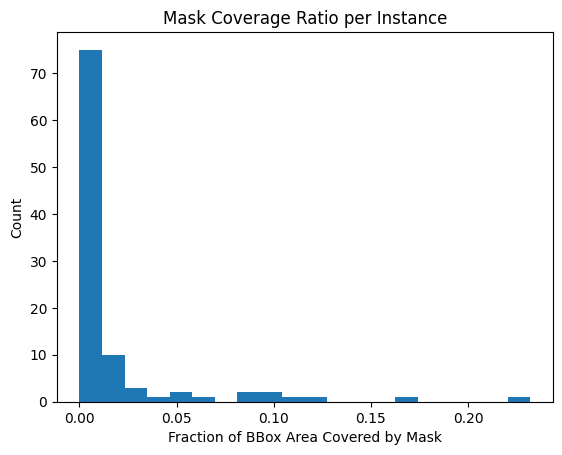

In [23]:
mask_coverage = []
for ann in filtered_annotations[:100]:  # Sample 100
    mask = coco_train.annToMask(ann)
    coverage = mask.sum()/(mask.shape[0]*mask.shape[1])
    mask_coverage.append(coverage)

plt.hist(mask_coverage, bins=20)
plt.title('Mask Coverage Ratio per Instance')
plt.xlabel('Fraction of BBox Area Covered by Mask')
plt.ylabel('Count')

Registered classes: ['cake', 'car', 'dog', 'person']
Verifying dataset loading...
Loaded 300 images for train set.


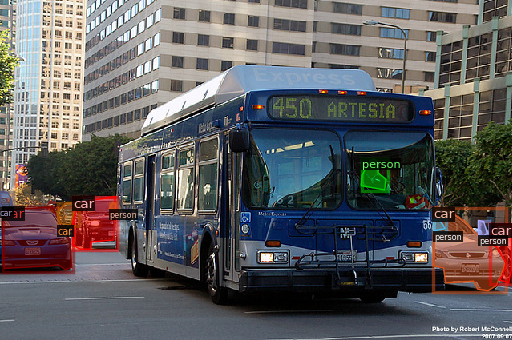

Saved visualization: /content/drive/MyDrive/panoptic_output/train_sample_1.png


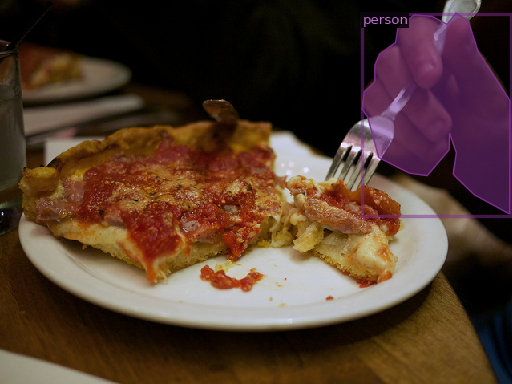

Saved visualization: /content/drive/MyDrive/panoptic_output/train_sample_2.png


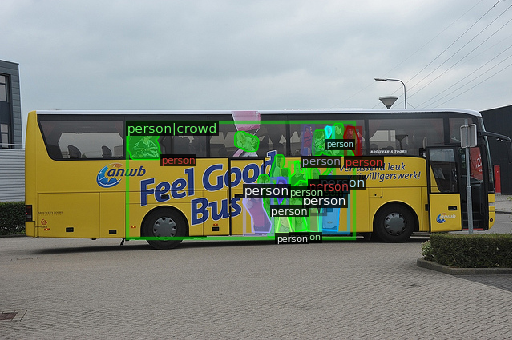

Saved visualization: /content/drive/MyDrive/panoptic_output/train_sample_3.png
Successfully visualized 3 samples from train set.
Loaded 300 images for val set.


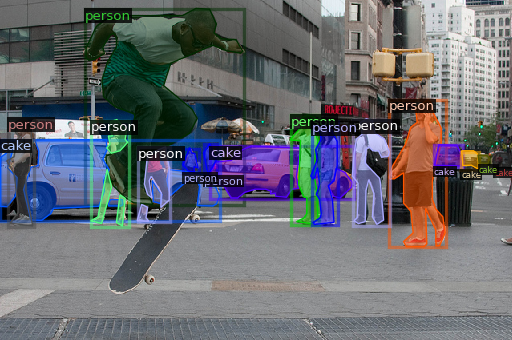

Saved visualization: /content/drive/MyDrive/panoptic_output/val_sample_1.png


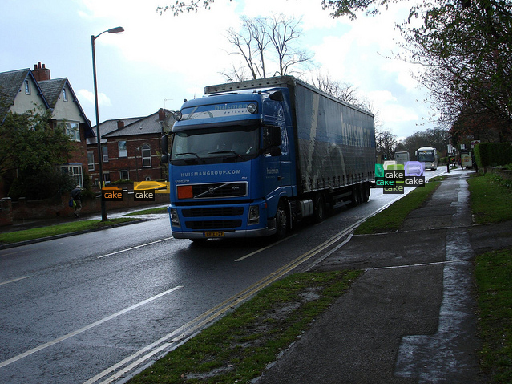

Saved visualization: /content/drive/MyDrive/panoptic_output/val_sample_2.png


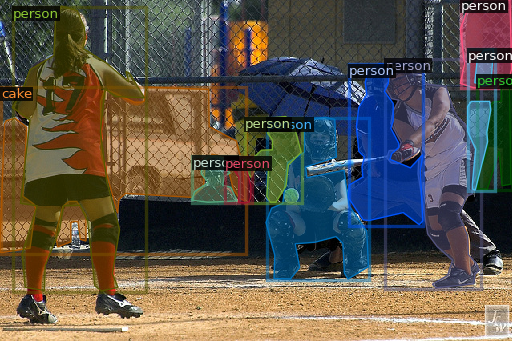

Saved visualization: /content/drive/MyDrive/panoptic_output/val_sample_3.png
Successfully visualized 3 samples from val set.


In [ ]:
dataset_metadata = MetadataCatalog.get("my_coco_train_custom")
print(f"Registered classes: {dataset_metadata.thing_classes}")

# Verify dataset loading by visualizing samples (as per provided snippet)
print("Verifying dataset loading...")
for d in ["train", "val"]:
    dataset_name = f"my_coco_{d}_custom"
    try:
        dataset_dicts = DatasetCatalog.get(dataset_name)
        print(f"Loaded {len(dataset_dicts)} images for {d} set.")
        if len(dataset_dicts) > 0:
            for i, sample in enumerate(random.sample(dataset_dicts, min(3, len(dataset_dicts)))):
                img_path = sample["file_name"]
                if not os.path.exists(img_path):
                    print(f"Image not found for visualization: {img_path}")
                    continue
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.8)
                out = visualizer.draw_dataset_dict(sample)
                cv2_imshow(out.get_image()[:, :, ::-1])
                output_path = os.path.join(TRAIN_OUTPUT_DIR, f'{d}_sample_{i+1}.png')
                cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
                print(f"Saved visualization: {output_path}")
            print(f"Successfully visualized {min(3, len(dataset_dicts))} samples from {d} set.")
        else:
            print(f"No samples loaded for {d} set. Please check your dataset path and JSON file.")
    except Exception as e:
        print(f"Error visualizing {d} set: {e}")


In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Debug: Check datasets before training
print("Datasets before training:", list(DatasetCatalog))
print("Metadata for my_coco_train_custom:", MetadataCatalog.get("my_coco_train_custom").thing_classes)
print("Metadata for my_coco_val_custom:", MetadataCatalog.get("my_coco_val_custom").thing_classes)

# --- Step 4: Model Training ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_coco_train_custom",)
cfg.DATASETS.TEST = ("my_coco_val_custom",)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # ~20 epochs for 300 images
cfg.SOLVER.STEPS = (3600, 4800)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.OUTPUT_DIR = TRAIN_OUTPUT_DIR

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        return torch.optim.SGD(model.parameters(), lr=cfg.SOLVER.BASE_LR, momentum=0.9, weight_decay=0.001)

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Save model
torch.save(trainer.model.state_dict(), MODEL_PATH)
print(f"Saved trained model to {MODEL_PATH}")


Datasets before training: ['my_coco_train_custom', 'my_coco_val_custom']
Metadata for my_coco_train_custom: ['cake', 'car', 'dog', 'person']
Metadata for my_coco_val_custom: ['cake', 'car', 'dog', 'person']
[06/16 19:16:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): 

model_final_f10217.pkl: 178MB [00:01, 117MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/16 19:17:00 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/16 19:17:13 d2.utils.events]:  eta: 0:27:55  iter: 19  total_loss: 3.069  loss_cls: 1.682  loss_box_reg: 0.5554  loss_mask: 0.6949  loss_rpn_cls: 0.03737  loss_rpn_loc: 0.07372    time: 0.5525  last_time: 0.5569  data_time: 0.1643  last_data_time: 0.1883   lr: 4.9953e-06  max_mem: 9028M
[06/16 19:17:28 d2.utils.events]:  eta: 0:27:30  iter: 39  total_loss: 2.951  loss_cls: 1.591  loss_box_reg: 0.5698  loss_mask: 0.6931  loss_rpn_cls: 0.03717  loss_rpn_loc: 0.06365    time: 0.5459  last_time: 0.6127  data_time: 0.1546  last_data_time: 0.2009   lr: 9.9902e-06  max_mem: 9028M
[06/16 19:17:39 d2.utils.events]:  eta: 0:27:22  iter: 59  total_loss: 2.834  loss_cls: 1.432  loss_box_reg: 0.579  loss_mask: 0.6885  loss_rpn_cls: 0.03642  loss_rpn_loc: 0.06854    time: 0.5446  last_time: 0.6413  data_time: 0.1550  last_data_time: 0.2602   lr: 1.4985e-05  max_mem: 9028M
[06/16 19:17:50 d2.utils.events]:  eta: 0:26:57  iter: 79  total_loss: 2.515  loss_cls: 1.209  loss_box_reg: 0.5255  loss_mas

In [ ]:
# --- Step 5: Validation Set Evaluation ---
cfg.MODEL.WEIGHTS = MODEL_PATH

predictor = DefaultPredictor(cfg)

print("\n--- Evaluating Validation Set ---")
evaluator = COCOEvaluator("my_coco_val_custom", tasks=("segm", "bbox"), distributed=False, output_dir=TRAIN_OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "my_coco_val_custom")
eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Print key metrics
print("\nValidation Results:")
print(f"Segmentation AP (mIoU approximation): {eval_results.get('segm', {}).get('AP', 0):.4f}")
print(f"Bounding Box AP: {eval_results.get('bbox', {}).get('AP', 0):.4f}")
print(f"Approximate Panoptic Quality (PQ): {eval_results.get('segm', {}).get('AP', 0):.4f}")


[06/16 19:44:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/panoptic_4classes.pth ...

--- Evaluating Validation Set ---
[06/16 19:44:37 d2.data.datasets.coco]: Loaded 300 images in COCO format from /content/dataset/validation-300/labels_filtered.json
[06/16 19:44:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/16 19:44:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/16 19:44:37 d2.data.common]: Serializing 300 elements to byte tensors and concatenating them all ...
[06/16 19:44:37 d2.data.common]: Serialized dataset takes 0.72 MiB
[06/16 19:44:37 d2.evaluation.evaluator]: Start inference on 300 batches
[06/16 19:44:38 d2.evaluation.evaluator]: Inference done 11/300. Dataloading: 0.0013 s/iter. Inference: 0.0507 s/iter. Eval: 0.0087 s/iter. Total: 0.0607

In [ ]:
# Save evaluation results
eval_output_path = os.path.join(TRAIN_OUTPUT_DIR, 'validation_results.json')
with open(eval_output_path, 'w') as f:
    json.dump(eval_results, f)
print(f"Saved evaluation results to {eval_output_path}")

Saved evaluation results to /content/drive/MyDrive/panoptic_output/validation_results.json



--- Performing Inference on Test Images from: /content/dataset/test-30 ---

Processing test image 1/3: 000000001492.jpg
Saved semantic mask: /content/drive/MyDrive/test_predictions/000000001492_semantic.png
Saved instance mask: /content/drive/MyDrive/test_predictions/000000001492_instance.png


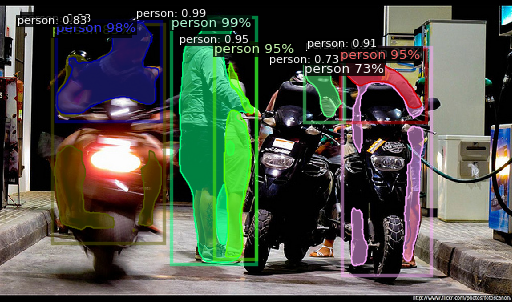

Saved visualization: /content/drive/MyDrive/test_predictions/test_result_000000001492.png

Processing test image 2/3: 000000001410.jpg
Saved semantic mask: /content/drive/MyDrive/test_predictions/000000001410_semantic.png
Saved instance mask: /content/drive/MyDrive/test_predictions/000000001410_instance.png


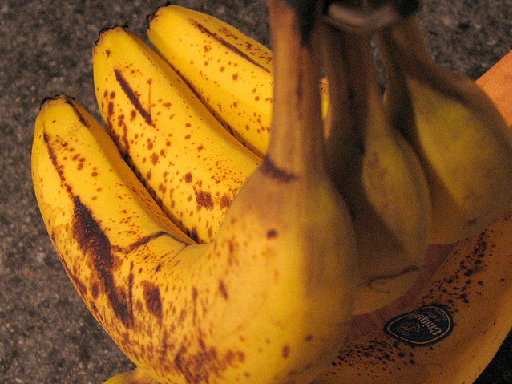

Saved visualization: /content/drive/MyDrive/test_predictions/test_result_000000001410.png

Processing test image 3/3: 000000001730.jpg
Saved semantic mask: /content/drive/MyDrive/test_predictions/000000001730_semantic.png
Saved instance mask: /content/drive/MyDrive/test_predictions/000000001730_instance.png


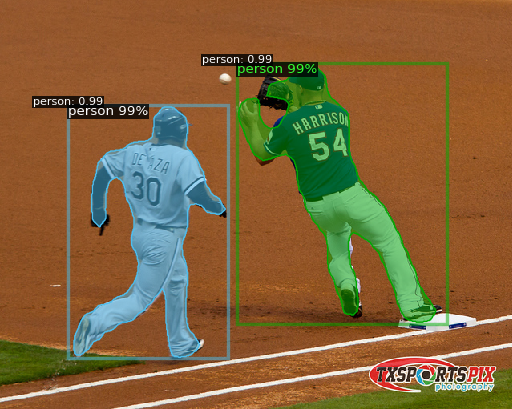

Saved visualization: /content/drive/MyDrive/test_predictions/test_result_000000001730.png

Saved 3 predictions to /content/drive/MyDrive/test_predictions/panoptic_predictions.json

Inference on test images complete.


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import random
from PIL import Image
import json
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.structures import Instances
from detectron2.utils.visualizer import GenericMask
from google.colab.patches import cv2_imshow

# Test inference
if not os.path.exists(TEST_IMAGES_DIR):
    print(f"Test images directory not found at {TEST_IMAGES_DIR}. Please create it or adjust the path.")
else:
    print(f"\n--- Performing Inference on Test Images from: {TEST_IMAGES_DIR} ---")
    test_image_paths = [f for f in glob(os.path.join(TEST_IMAGES_DIR, '*.*')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(test_image_paths)  # Shuffle for random selection

    # Select up to 3 test images
    num_test_visualizations = min(3, len(test_image_paths))

    if num_test_visualizations == 0:
        print("No image files found in the test directory to visualize.")
    else:
        dataset_metadata = MetadataCatalog.get("my_coco_train_custom")
        predictions = []
        score_threshold = 0.7  # Increase threshold to filter low-confidence predictions

        for i in range(num_test_visualizations):
            img_path = test_image_paths[i]
            im = cv2.imread(img_path)
            if im is None:
                print(f"Could not read image: {img_path}. Skipping.")
                continue

            print(f"\nProcessing test image {i+1}/{num_test_visualizations}: {os.path.basename(img_path)}")

            # Perform inference
            outputs = predictor(im)
            instances = outputs["instances"].to("cpu")

            # Filter predictions by confidence score
            keep = instances.scores > score_threshold
            filtered_instances = Instances(
                image_size=instances.image_size,
                pred_boxes=instances.pred_boxes[keep],
                scores=instances.scores[keep],
                pred_classes=instances.pred_classes[keep],
                pred_masks=instances.pred_masks[keep]
            )

            # Optional: Apply NMS (uncomment to enable)
            # from detectron2.structures import nms
            # keep = nms(filtered_instances.pred_boxes.tensor, filtered_instances.scores, iou_threshold=0.5)
            # filtered_instances = filtered_instances[keep]

            pred_masks = filtered_instances.pred_masks.numpy()  # [N, H, W]
            pred_classes = filtered_instances.pred_classes.numpy()  # [N]
            pred_scores = filtered_instances.scores.numpy()  # [N]

            # Generate semantic and instance masks
            semantic_mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)
            instance_mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint32)
            instance_id = 1
            for j, (mask, class_id) in enumerate(zip(pred_masks, pred_classes)):
                if class_id < len(dataset_metadata.thing_classes):
                    class_name = dataset_metadata.thing_classes[class_id]
                    class_id_mapped = {'cake': 1, 'car': 2, 'dog': 3, 'person': 4}.get(class_name, 0)
                    if class_id_mapped > 0:
                        semantic_mask[mask] = class_id_mapped
                        instance_mask[mask] = instance_id
                        instance_id += 1

            # Save masks
            semantic_output_path = os.path.join(OUTPUT_DIR, os.path.basename(img_path).rsplit('.', 1)[0] + '_semantic.png')
            Image.fromarray(semantic_mask).save(semantic_output_path)
            print(f"Saved semantic mask: {semantic_output_path}")

            instance_output_path = os.path.join(OUTPUT_DIR, os.path.basename(img_path).rsplit('.', 1)[0] + '_instance.png')
            Image.fromarray(instance_mask).save(instance_output_path)
            print(f"Saved instance mask: {instance_output_path}")

            # Visualize with confidence scores
            v = Visualizer(im[:, :, ::-1], metadata=dataset_metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
            out = v.draw_instance_predictions(filtered_instances)
            # Overlay confidence scores
            for box, score, class_id in zip(filtered_instances.pred_boxes.tensor.cpu().numpy(), pred_scores, pred_classes):
                if class_id < len(dataset_metadata.thing_classes):
                    class_name = dataset_metadata.thing_classes[class_id]
                    x0, y0, x1, y1 = box
                    v.draw_text(f"{class_name}: {score:.2f}", (x0, y0 - 10), font_size=10, color="white")
            visualized_img = out.get_image()[:, :, ::-1]
            cv2_imshow(visualized_img)

            # Save visualization
            vis_output_path = os.path.join(OUTPUT_DIR, f'test_result_{os.path.basename(img_path).rsplit(".", 1)[0]}.png')
            cv2.imwrite(vis_output_path, visualized_img)
            print(f"Saved visualization: {vis_output_path}")

            # Store predictions
            predictions.append({
                'image': os.path.basename(img_path),
                'semantic_mask': semantic_mask.tolist(),
                'instance_mask': instance_mask.tolist(),
                'scores': pred_scores.tolist()  # Store scores for debugging
            })

        # Save predictions to JSON
        json_output_path = os.path.join(OUTPUT_DIR, 'panoptic_predictions.json')
        with open(json_output_path, 'w') as f:
            json.dump(predictions, f)
        print(f"\nSaved {len(predictions)} predictions to {json_output_path}")

        print("\nInference on test images complete.")